In [461]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.utils.data
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

In [462]:
hid = 5
m = 30000
n = 10

In [463]:
W1 = np.random.randn(n, hid)*10
b1 = np.random.randn(n)*10
w2 = np.asarray([0,-3,5,0,8])
b2 = np.asarray([10])

In [464]:
X = np.random.randn(m, n)
# Z = (X @ W1)*((X @ W1) > 0)
Z = np.tanh(X @ W1/30)
y = Z @ w2 + b2

In [465]:
def get_loader(X, y, batch_size=64):
    train = torch.utils.data.TensorDataset(torch.from_numpy(X).float(), 
                                       torch.from_numpy(y).float())
    train_loader = torch.utils.data.DataLoader(train, 
                                               batch_size=batch_size)
    return train_loader

In [466]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.5)

In [467]:
train_loader = get_loader(X_train, y_train) 
test_loader = get_loader(X_test, y_test)

In [468]:
class DenseNet(nn.Module):
    def __init__(self, in_ch, hid_ch):
        super(DenseNet, self).__init__()
        self.linear1 = nn.Linear(in_ch, hid_ch)
        self.linear2 = nn.Linear(hid_ch, 1)
        self.Z = None


    def forward(self, x):
        Z = torch.tanh(self.linear1(x))
        self.Z = Z
        out = self.linear2(Z)
        return out.view(-1)

In [469]:
def train_epoch(model, optimizer, train_loader, criterion):
    model.train()
    for X, y in train_loader:
        out = model(X)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [470]:
def evaluate_loss(loader, model):
    with torch.no_grad():
        model.eval()
        loss = 0
        k = 0
        for x, y in loader:
            k += y.shape[0]
            out = model(x)
            loss += criterion(out, y.float()).numpy() 
        loss /= k
    return loss

In [471]:
def train(model, opt, train_loader, test_loader, criterion, n_epochs, verbose=True):
    train_log = []
    val_log = []
    for epoch in range(n_epochs):
        train_epoch(model, opt, train_loader, criterion)
        train_loss = evaluate_loss(train_loader, model)
        val_loss = evaluate_loss(test_loader, model)
        train_log.append(train_loss)
        val_log.append(val_loss)
        if verbose:
             print (('Epoch [%d/%d], Loss (train/test): %.4f/%.4f,')
                   %(epoch+1, n_epochs, \
                     train_loss, val_loss))
            
    return train_log, val_log

In [477]:
model = DenseNet(n, hid)

In [478]:
optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)
criterion = nn.MSELoss()

In [479]:
train_log, test_log = train(model, optimizer, train_loader, test_loader, criterion, 20, verbose=False)

0.00013038632295404873


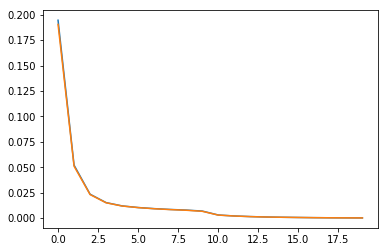

In [480]:
plt.plot(train_log)
_=plt.plot(test_log)
print(test_log[-1])

In [481]:
for i in model.parameters():
    print(i)

Parameter containing:
tensor([[-0.0131, -0.0554,  0.0108,  0.0400,  0.0709,  0.1263, -0.0437, -0.0910,
         -0.1096, -0.0536],
        [-0.0363,  0.1215, -0.0721,  0.0438,  0.0538, -0.0187, -0.0751, -0.0777,
          0.2172, -0.0174],
        [ 0.1246, -0.4635,  0.1799, -0.0434, -0.0492,  0.0087,  0.3507,  0.0083,
         -0.3762, -0.5629],
        [ 0.0800, -0.0881,  0.2060, -0.2679, -0.4094, -0.3835,  0.3046,  0.5096,
         -0.2023,  0.2292],
        [-0.0288, -0.3397,  0.0907,  0.1348,  0.1874,  0.5909, -0.1844, -0.1775,
         -0.8368,  0.1254]], requires_grad=True)
Parameter containing:
tensor([-1.4399,  1.9578, -0.0194, -0.0124,  0.0151], requires_grad=True)
Parameter containing:
tensor([[-3.9917,  3.9517,  3.2912,  4.9418, -7.2531]], requires_grad=True)
Parameter containing:
tensor([2.8312], requires_grad=True)


In [482]:
y_pred = model(torch.Tensor(X))
errors =y_pred.data.numpy() - y

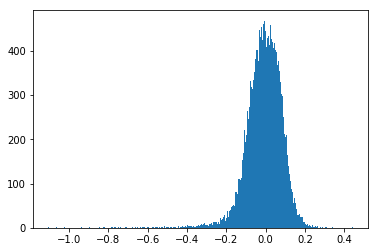

In [484]:
_=plt.hist(errors, bins=500)